In [161]:
import cv2
import os
import random
import shutil
import pathlib
import itertools
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from IPython.core.display import Image
from tensorflow.keras.applications import VGG16
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageEnhance
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import joblib

In [51]:
train = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

In [54]:
train_paths = []
train_labels = []

for label in os.listdir(train):
    for image in os.listdir(train+label):
        train_paths.append(train+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

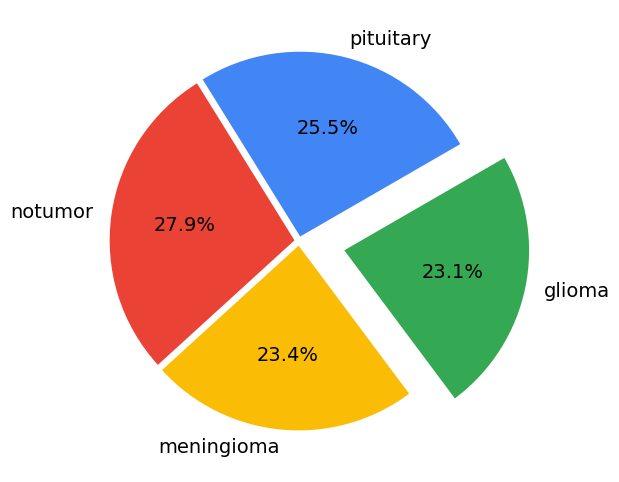

In [60]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.25),
        startangle=30);

In [57]:
test_paths = []
test_labels = []

for label in os.listdir(test):
    for image in os.listdir(test+label):
        test_paths.append(test+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

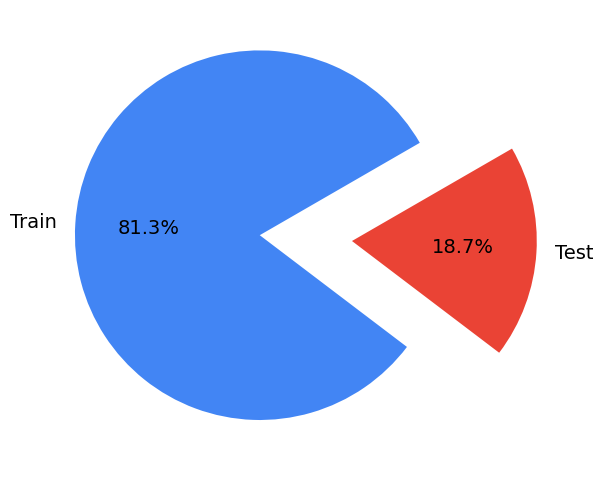

In [61]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.5,0),
        startangle=30);

In [71]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

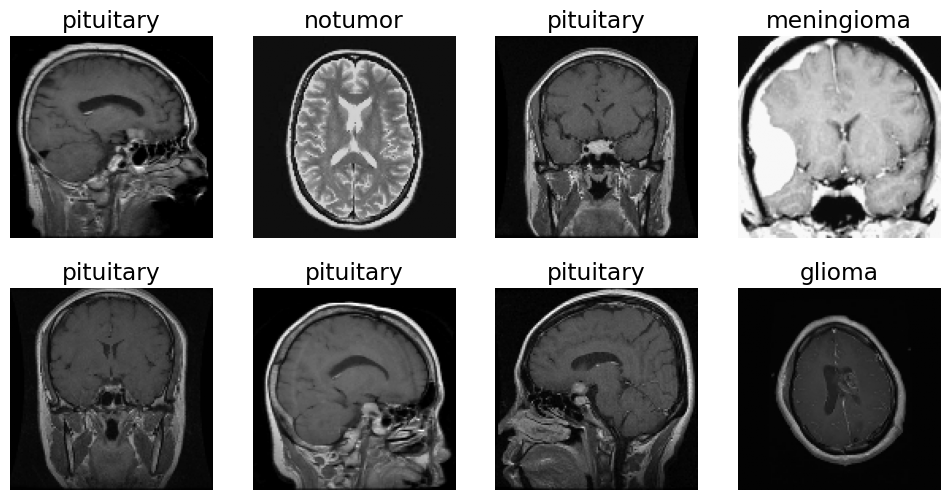

In [74]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [76]:
unique_labels = os.listdir(train)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_16 (Dropout)        (None, 8192)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

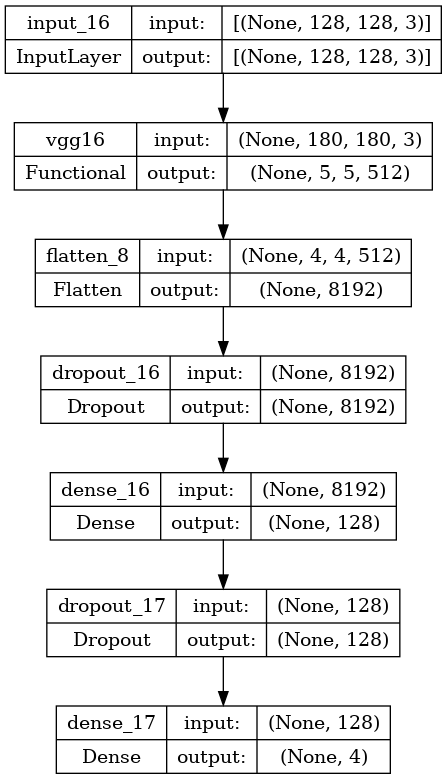

In [149]:
def CNN_Model():
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=(img_width, img_height, 3))
    
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu'))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(len(unique_labels), activation='softmax'))
    
    return CNN


model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  

keras.utils.plot_model(model, show_shapes=True)

In [95]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_14 (Dropout)        (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [96]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [97]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 [==============================] - 449s 2s/step - loss: 0.4619 - accuracy: 0.8239
Epoch 2/10
285/285 [==============================] - 445s 2s/step - loss: 0.2376 - accuracy: 0.9104
Epoch 3/10
285/285 [==============================] - 444s 2s/step - loss: 0.1535 - accuracy: 0.9410
Epoch 4/10
285/285 [==============================] - 446s 2s/step - loss: 0.1186 - accuracy: 0.9548
Epoch 5/10
285/285 [==============================] - 453s 2s/step - loss: 0.0885 - accuracy: 0.9649
Epoch 6/10
285/285 [==============================] - 455s 2s/step - loss: 0.0554 - accuracy: 0.9789
Epoch 7/10
285/285 [==============================] - 455s 2s/step - loss: 0.0606 - accuracy: 0.9791
Epoch 8/10
285/285 [==============================] - 453s 2s/step - loss: 0.0487 - accuracy: 0.9828
Epoch 9/10
285/285 [==============================] - 452s 2s/step - loss: 0.0369 - accuracy: 0.9859
Epoch 10/10
285/285 [==============================] - 451s 2s/step - loss: 0.0372 - accura

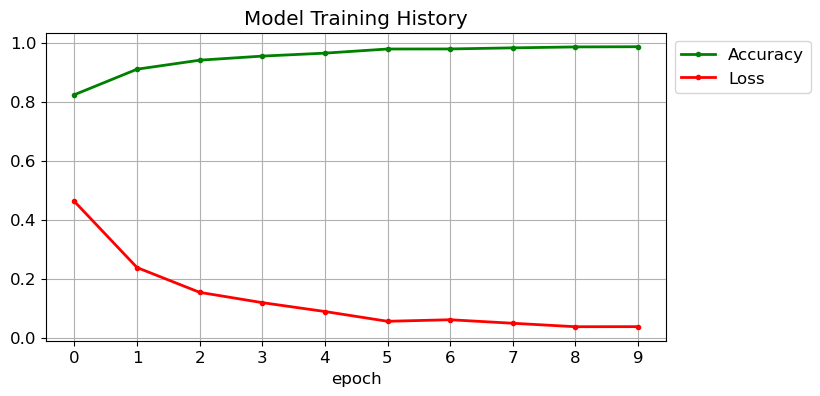

In [99]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [148]:
model.save('CNN_model.h5')
print ("Model saved successfully!")

Model saved successfully!
